# Example notebook for the ATOM pipeline
---------------------------------

Download the Australian weather dataset from kaggle at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package.  
  
**Description:** Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow.

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

# Load the Australian weather dataset
X = pd.read_csv('weatherAUS.csv')
X = X.drop(['RISK_MM', 'Date'], axis=1)  # Drop unrelated features

In [2]:
# Call ATOM using only a percentage of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, target="RainTomorrow", percentage=5, log='log', verbose=3, random_state=2)

<<=============== ATOM ===============>>
Initial data cleaning...
 --> Dropping 45 duplicate rows.
Algorithm task: binary classification.

Data stats =====================>
Number of features: 21
Number of instances: 7107
Size of training set: 4974
Size of test set: 2133
Instances per target class:
RainTomorrow --> Count
0: No        --> 5554
1: Yes       --> 1553



In [3]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='missing', max_frac=0.8)

Handling missing values...
 --> Imputing 18 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 8 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 49 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2175 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2416 missing values using the KNN imputer in feature Sunshine.
 --> Imputing 282 missing values with missing in feature WindGustDir.
 --> Imputing 278 missing values using the KNN imputer in feature WindGustSpeed.
 --> Imputing 338 missing values with missing in feature WindDir9am.
 --> Imputing 117 missing values with missing in feature WindDir3pm.
 --> Imputing 40 missing values using the KNN imputer in feature WindSpeed9am.
 --> Imputing 80 missing values using the KNN imputer in feature WindSpeed3pm.
 --> Imputing 62 missing values using the KNN imputer in feature Humidity9am.
 --> Imputing 137 missing values using the KNN imputer in feature Hum

In [4]:
# Encode the categorical features
atom.encode(max_onehot=10, fraction_to_other=0.01)

Encoding categorical features...
 --> Target-encoding feature Location. Contains 49 unique categories.
 --> Target-encoding feature WindGustDir. Contains 17 unique categories.
 --> Target-encoding feature WindDir9am. Contains 17 unique categories.
 --> Target-encoding feature WindDir3pm. Contains 17 unique categories.
 --> One-hot-encoding feature RainToday. Contains 3 unique categories.


In [5]:
# Select only the best 10 features
atom.feature_selection(strategy="univariate", solver='f_classif', max_features=15, max_correlation=0.8)

# See which features were removed due to collinearity
atom.collinear

Performing feature selection...
 --> Feature Pressure3pm was removed due to collinearity with another feature.
 --> Feature Temp9am was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.
 --> Feature RainToday_Yes was removed due to collinearity with another feature.
 --> Feature MinTemp was removed after the univariate test (score: 54.40  p-value: 0.00).
 --> Feature Evaporation was removed after the univariate test (score: 63.07  p-value: 0.00).
 --> Feature WindGustDir was removed after the univariate test (score: 123.52  p-value: 0.00).
 --> Feature WindDir3pm was removed after the univariate test (score: 112.96  p-value: 0.00).
 --> Feature WindSpeed9am was removed after the univariate test (score: 63.29  p-value: 0.00).
 --> Feature WindSpeed3pm was removed after the univariate test (score: 47.38  p-value: 0.00).
 --> Feature Temp9am was removed after the univariate test (score: 0.79  p-value: 0.38).
 --> F

,drop_feature,correlated_feature,correlation_value
0,Pressure3pm,Pressure9am,0.95952
1,Temp9am,"MinTemp, MaxTemp","0.8999, 0.87906"
2,Temp3pm,"MaxTemp, Temp9am","0.96302, 0.84204"
3,RainToday_Yes,RainToday_No,-0.97249


In [6]:
# Perform undersampling of the majority class to balance the dataset
atom.balance(undersample=0.8)

Using TensorFlow backend.


Performing undersampling...
 --> Removing 2522 rows from the majority class.


In [7]:
# Remove outliers from the training set
atom.outliers(max_sigma=5)

Handling outliers...
 --> Dropping 25 rows due to outliers.


In [8]:
# Change the verbosity of ATOM to not print too much details while fitting
atom.verbose = 1

# Let's compare the performance of the different gradient boosting algorithms
atom.fit(['gbm', 'xgb', 'lgb', 'catb'],
        metric='accuracy',  # You can use your own metric function as well
        max_iter=5,
        init_points=5,
        cv=1,
        bagging=5)


Running pipeline =================>


Processing:   0%|                                                                                | 0/4 [00:00<?, ?it/s]

Models in pipeline: GBM, XGB, LGB, CatB
Metric: accuracy_score


Processing: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:46<00:00, 26.74s/it]



Final results ================>>
Duration: 00h:01m:48s
Metric: accuracy_score
--------------------------------
Gradient Boosting Machine --> 0.650 ± 0.026
XGBoost                   --> 0.749 ± 0.007
LightGBM                  --> 0.760 ± 0.005
CatBoost                  --> 0.781 ± 0.008 !!


### CatBoost proved to be the best. Let's have a look at the model!

In [16]:
print('Best score on the test set: ', atom.CatB.score_test)

Best score on the test set:  0.7824660103141116


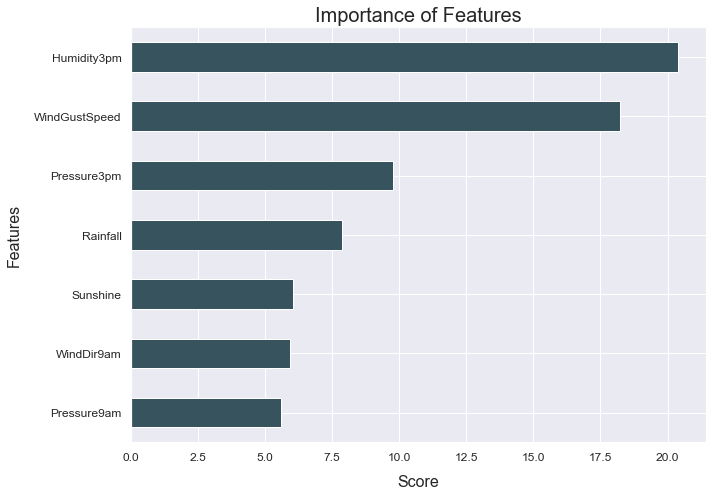

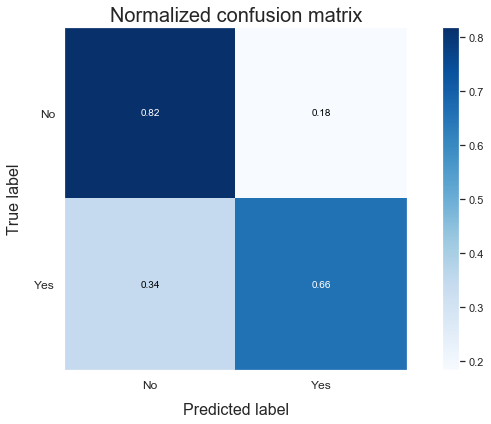

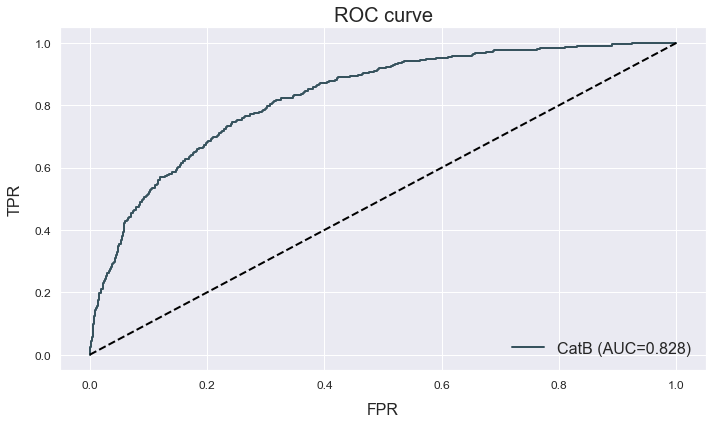

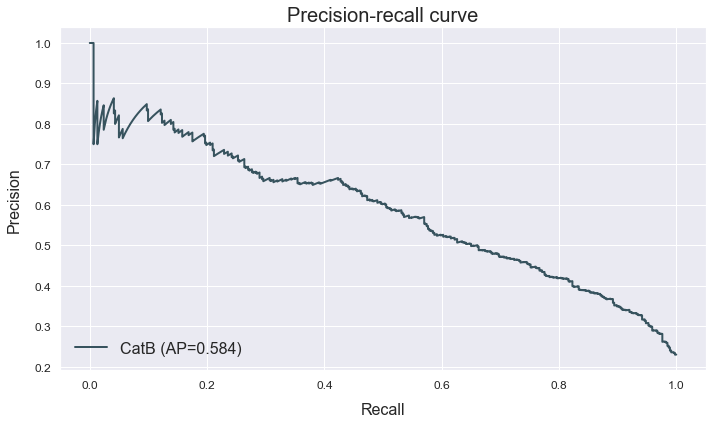

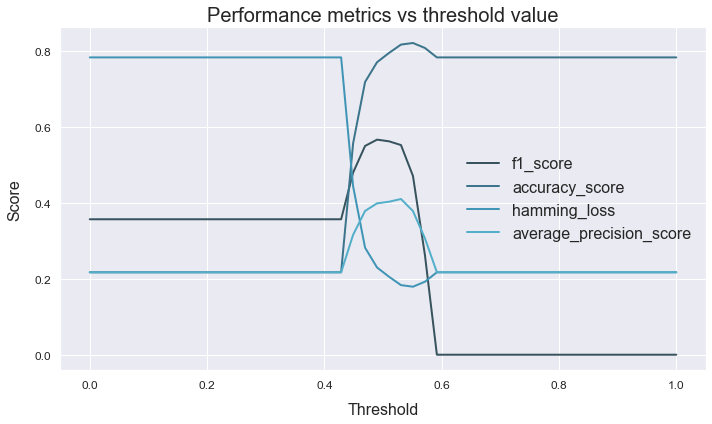

In [17]:
# Make some plots to analyze the results
atom.catb.plot_feature_importance(show=7, figsize=(10,7))
atom.catb.plot_confusion_matrix(filename='lgb_cm.png')
atom.catb.plot_ROC()
atom.catb.plot_PRC()
atom.catb.plot_threshold(metric=['f1', 'accuracy', 'hamming', 'ap'], steps=50)